In [111]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [112]:
img_id_caption = pd.read_csv("captions.txt", sep=',')
print(len(img_id_caption))
display(img_id_caption.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [113]:
from textwrap import wrap
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

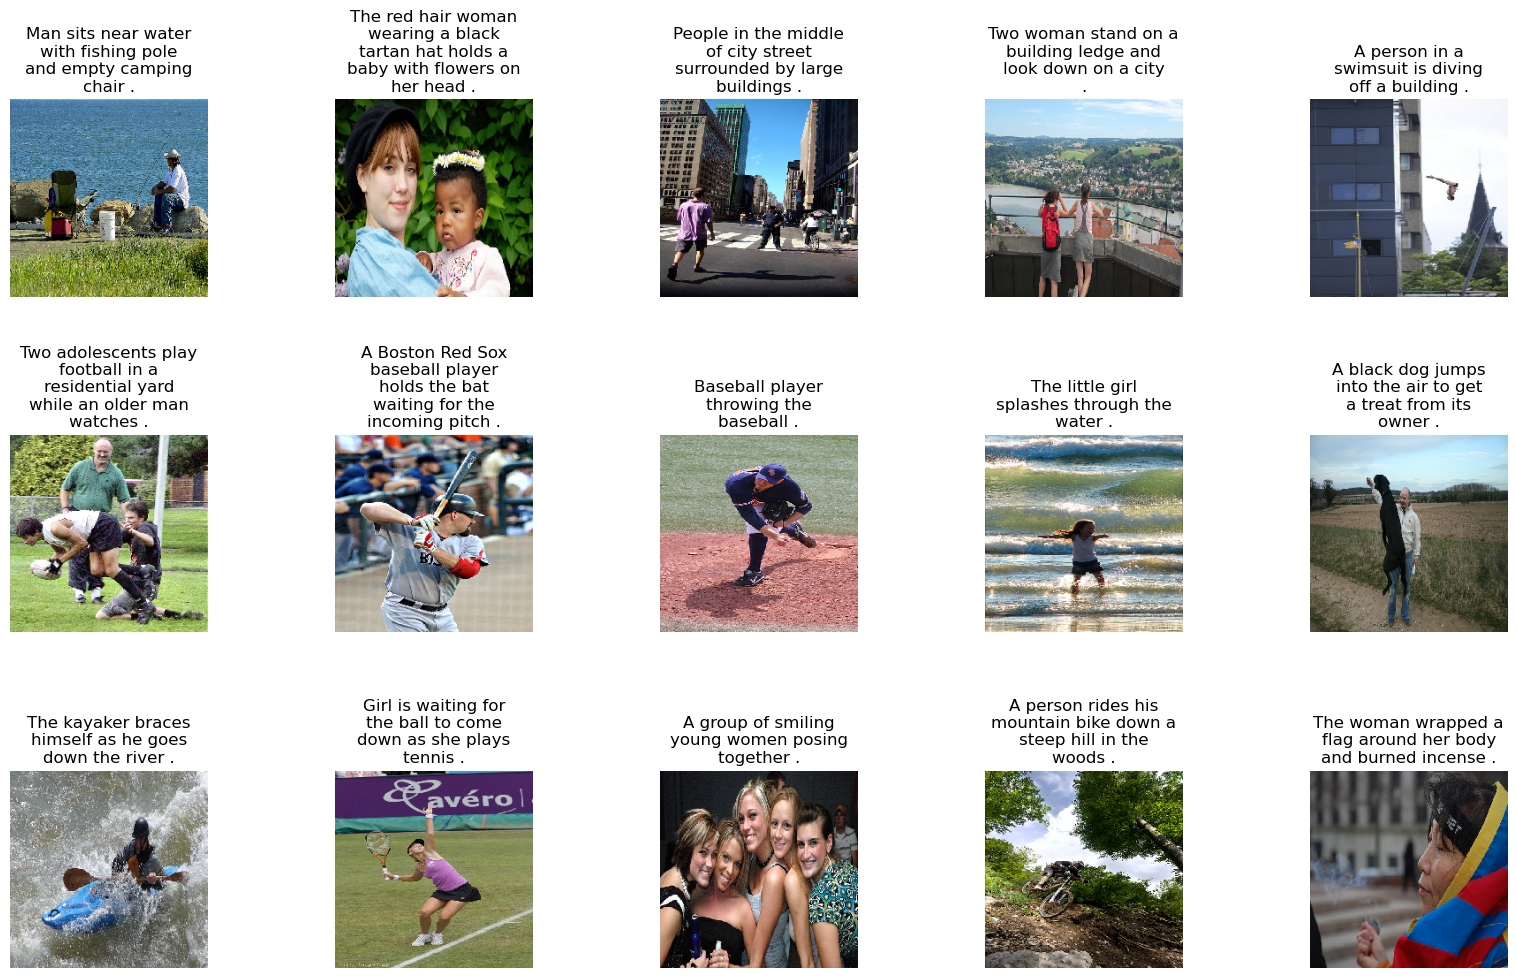

In [114]:
display_images(img_id_caption.sample(15))

In [115]:
import re
def process(data):
    clean_data=[]
    for word in data.split():
        if len(word)>1:
            word=word.lower()
            word=re.sub('[^A-za-z]','',word)
            clean_data.append(word)
            
    return clean_data

In [116]:
img_id_caption['cleaned_caption'] = img_id_caption['caption'].apply(lambda x: 'start '+' '.join(process(x))+ ' end')

In [117]:
img_id_caption.sample(5)

,image,caption,cleaned_caption
1469,1322323208_c7ecb742c6.jpg,Two young children playing with sticks at the ...,start two young children playing with sticks a...
6726,2257798999_d9d1b9a45a.jpg,"Orange , brown and white and brown dogs on gra...",start orange brown and white and brown dogs on...
2751,1501297480_8db52c15b0.jpg,A child wearing shorts is moving a window scre...,start child wearing shorts is moving window sc...
30228,3518675890_2f65e23ff9.jpg,The brown dog is running on the grass .,start the brown dog is running on the grass end
18949,3040033126_9f4b88261b.jpg,The dog is leaping into the water .,start the dog is leaping into the water end


In [118]:
all_captions = img_id_caption['cleaned_caption'].to_list()
len(all_captions)

40455

In [119]:

img_id_caption.drop(columns=['caption'],inplace=True)

In [120]:

caption_dict = {k: v.tolist() for k, v in img_id_caption.groupby('image')['cleaned_caption']}

In [121]:
image_id = list(caption_dict.keys())
len(image_id)

8091

In [122]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
voc_size = len(tokenizer.word_index)+1

In [123]:
tokenizer.texts_to_sequences([all_captions[0]])[0]


[2, 41, 3, 89, 169, 6, 118, 52, 394, 11, 391, 3, 27, 5193, 691, 1]

In [124]:
import pickle

pickle.dump(tokenizer,open("token.pkl","wb"))

In [125]:
max_caption_len = max([len(i.split()) for i in all_captions])

In [16]:
train_data = image_id[:int(len(image_id)*.90)]
val_data = image_id[int(len(image_id)*.90):]
len(train_data),len(val_data)

(7281, 810)

In [17]:
train_df = img_id_caption[img_id_caption['image'].isin(train_data)]
test_df = img_id_caption[img_id_caption['image'].isin(val_data)]

In [19]:
model = VGG16()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467096/553467096 [==============================] - 250s 0us/step


In [20]:
fe.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
features = {}
for img_name in tqdm(os.listdir('Images')):
    img_path = os.path.join('Images',img_name)
    img = load_img(img_path,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = fe.predict(img, verbose=0)
    features[img_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [22]:
def data_generator(data,caption_dict,features,tokenizer,max_length,voc_size,batch_size):
    x1=[]
    x2=[]
    y=[]
#     batch_size=64
    n=0
    while(1):
        for id in data:
            n+=1
            captions = caption_dict[id]
            for caption in captions:
                #Tokenizing the caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_caption_len)[0]
                    out_seq = to_categorical([out_seq],num_classes=voc_size)[0]
                    x1.append(features[id][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                x1,x2,y = np.array(x1),np.array(x2),np.array(y)
                yield [x1,x2],y
                x1,x2,y=list(),list(),list()
                n=0

In [23]:
generators = data_generator(train_data,caption_dict,features,tokenizer,max_caption_len,voc_size,64)

In [35]:
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256,activation='relu')(fe1)

#model for Caption
input2 = Input(shape=(max_caption_len))
se1 = Embedding(voc_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoding_the_sequences
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)

output = Dense(voc_size,activation='softmax')(decoder2)

model=Model(inputs=[input1,input2],outputs=output)

model.compile(loss='categorical_crossentropy',optimizer='adam')
#Plot_model

In [36]:
epochs=20
batch_size=32
steps=len(train_data)//batch_size

for i in range(epochs):
    generators = data_generator(train_data,caption_dict,features,tokenizer,max_caption_len,voc_size,batch_size)
    model.fit(generators,epochs=1,steps_per_epoch=steps,verbose=1)
    


227/227 [==============================] - 523s 2s/step - loss: 2.1836


In [37]:
model.save("model1.h5")

C:\Users\tumma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [39]:
def prediction(model,image,tokenizer,max_caption_len):
    in_text = 'start'
    for i in range(max_caption_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_caption_len)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text+=' '+ word
        if word=='end':
            break
    return in_text

In [40]:
from nltk.translate.bleu_score import corpus_bleu
actual,predicted = list(),list()

for img_id in tqdm(val_data):
    cations = caption_dict[img_id]
    y_pred = prediction(model,features[img_id],tokenizer,max_caption_len)
    actual_caption = [i.split() for i in cations]
    actual.append(actual_caption)
    predicted.append(y_pred.split())
    
    
print('BLEU_Score_1-->',corpus_bleu(actual,predicted,weights=(1,0,0,0,0)))
print('BLEU_Score_2-->',corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU_Score_1--> 0.5353887701136492
BLEU_Score_2--> 0.3095948543257408


In [70]:
from PIL import Image
def enter_image_for_caption_generate(image_name):
    image_path = os.path.join('Images',image_name)
    image = Image.open(image_path)
    captions = caption_dict[image_name]
    print("Actual_Captions--->")
    for i in captions:
        print(i)
    print('-'*50)
    y_pred = prediction(model,features[image_name],tokenizer,max_caption_len)
    print('predicted-->')
    print(y_pred)
    print('-'*50)
    plt.imshow(image)

In [109]:
from PIL import Image
def externel_caption_generate(image_name):
    img11 = Image.open(image_name)
    small_img = img11.resize((300, 300))

    display(small_img)
    img_path = image_name
    
    
    img = load_img(img_path,target_size=(224,224))
    #img.show()
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    ext_feature = fe.predict(img, verbose=0)
    
    y_pred = prediction(model,ext_feature,tokenizer,max_caption_len)
    print('predicted-->')
    print(y_pred)
    return y_pred[6:-4]


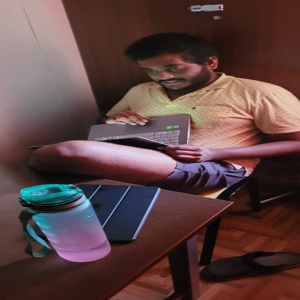

predicted-->
start little boy in pink shirt and blue shorts is sitting on his back end


'little boy in pink shirt and blue shorts is sitting on his back'

In [110]:
externel_caption_generate("C:\\Users\\tumma\\Downloads\\WhatsApp Image 2024-02-28 at 07.37.56.jpeg")

In [102]:
import pyttsx3

def text_to_speech(text):
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()

    rate = engine.getProperty('rate')
    engine.setProperty('rate', rate - 50)  

    # Set the voice (optional)
    voices = engine.getProperty('voices')
    engine.setProperty('voice', voices[0].id) 
    engine.say(text)
    engine.runAndWait()

# Example usage
text_to_speech(externel_caption_generate("D:\\SEM6\\DL\\data\\flickr30k_images\\flickr30k_images\\29389675.jpg"))


predicted-->
start man with pink headband and pink headband with pink headband with pink eyes in michael jackson standing in front of an umbrella end


In [1]:
externel_caption_generate("C:\Users\YASWANTH\Downloads\pexels-nishant-aneja-2477374.jpg")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3470083301.py, line 1)